In [6]:
import itertools
import math
import pickle
import json

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import poisson, nbinom
import pandas as pd

# Parameters

In [7]:
initial_cases = 10

# sweep over [0.0 - 1.0]  # based on travel rates
imported_cases_per_step = .5  # really, there's a cost to setting this too, if we make it part of the action space
imported_cases_per_step_range = np.arange(0.0, 1.0, 0.2)

# .97 - .98
# .97 ** (6*30 / 4) == 0.25
# .98 ** (6*30 / 4) == 0.4
#   --> credence assigned to NO vaccine in 6 months
#        strikes balance of giving a fair chance of 6 month vaccine; while not giving high chance to vaccine in 2-months
discount = 0.99

# time step: ~4 days  (1 generation period)
num_population = 1000

In [8]:
imported_cases_per_step_range

array([0. , 0.2, 0.4, 0.6, 0.8])

In [9]:
# is this really a fair form? 
# wouldn't keeping everyone home for 6 weeks have some finite cost?

# Cost of setting R
R_0 = 2.5   # 2.8? #3?  look up; depends on the place

# sweep:  [1, 3]
power = 2
power_range = np.arange(1.0, 3.0, 0.5)

# average person's annual economic contribution: $50,000?
economic_contribution_annual = 50000
economic_contribution_2_weeks = economic_contribution_annual * 2.0 / 52
cost_to_keep_half_home = num_population / 2 * economic_contribution_2_weeks

# want: cost_of_r(R_0 / 4) == cost_to_keep_half_home
# Better: how much economic loss has the US had, to keep R ~= 1
# (1/((R_0/4)**power) - 1/(R_0 ** power)) * scale_factor == cost_to_keep_half_home
# scale_factor = cost_to_keep_half_home / (1/((R_0/4)**power) - 1/(R_0 ** power))

# population of 100,000:
# R = 1 for 4 days  ~=  100 people getting sick (25 ppl / day * 4 days)
# every 20 days: 500 people sick -> 5 person dead

# cost_of_r(1.0) == cost_of_n(100) == cost of 1 death + other bad effects ?= $4,000,000
# [1/(1 ** power) - 1/(R_0 ** power)] * scale_factor == 100
# scale_factor = 100 / [1 - 1/(R_0 ** power)]

scale_factor = 100
scale_factor_range = [100, 500, 1000]

def cost_of_r(r, power=2, scale_factor=100, **kwargs):
    baseline = 1/(R_0 ** power)
    actual = 1/(r ** power)
    
    # cost_to_keep_half_home / (1/((num_population/4)**power) - 1/(R_0 ** power))
    
    if r >= R_0:
        return 0
    else:
        return (actual - baseline) * scale_factor  # (actual - baseline)
    #return actual

10
[0.5 0.6 0.7 0.8 0.9 1.  1.1 1.5 2.  2.5]


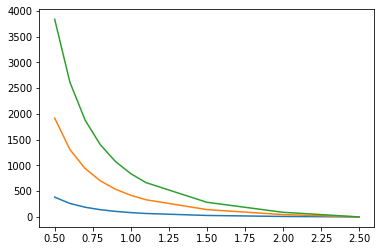

In [10]:
rs = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.5, 2.0, 2.5])
rs = rs[4:]
costs_of_r_100 = [cost_of_r(r) for r in rs]
costs_of_r_500 = [cost_of_r(r, scale_factor=500) for r in rs]
costs_of_r_1000 = [cost_of_r(r, scale_factor=1000) for r in rs]
sns.lineplot(x=rs, y=costs_of_r_100)
sns.lineplot(x=rs, y=costs_of_r_500)
sns.lineplot(x=rs, y=costs_of_r_1000)
actions = rs
num_actions = len(actions)
print(num_actions)
print(actions)

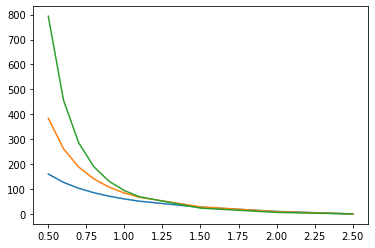

In [11]:
costs_of_r_power_1 = [cost_of_r(r, power=1) for r in rs]
costs_of_r_power_2 = [cost_of_r(r, power=2) for r in rs]
costs_of_r_power_3 = [cost_of_r(r, power=3) for r in rs]
sns.lineplot(x=rs, y=costs_of_r_power_1)
sns.lineplot(x=rs, y=costs_of_r_power_2)
sns.lineplot(x=rs, y=costs_of_r_power_3)

[1.  1.5 2.  2.5]
[100, 500, 1000]


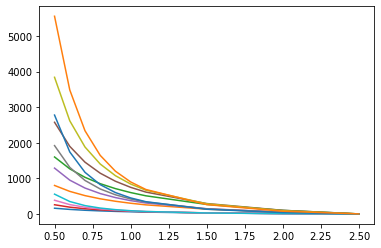

In [12]:
for power in power_range:
    for scale_factor in scale_factor_range:
        costs_of_r = [cost_of_r(r, power=power, scale_factor=scale_factor) for r in rs]
        sns.lineplot(x=rs, y=costs_of_r)
# sns.lineplot(x=rs, y=costs_of_r_best)
print(power_range)
print(scale_factor_range)

In [13]:
cost_of_r(2.5) - cost_of_r(2.0)

-9.0

In [14]:
# Cost of N (number of cases)
# assume cost of someone getting sick is $40,000

'''fraction_need_hospital = 0.04
cost_per_hospital_visit = 50000
cost_per_death = 1e6

# cost_of_n(n) == n
# cost_of_r(1.0) == cost_of_n(100) == 100

hospital_capacity = 25 # 5% of population #  20000

death_rate_hospital = 0.25
death_rate_neglected = 0.9'''


def cost_of_n(n, **kwargs):
    if n <= 0:
        return 0
    else:
        return n
    
    '''    num_need_hospital = n * fraction_need_hospital
        num_hospital = min(num_need_hospital, hospital_capacity)
        num_neglected = num_need_hospital - num_hospital
        num_deaths = num_neglected * death_rate_neglected + num_hospital * death_rate_hospital
        
        return cost_per_hospital_visit * num_hospital + cost_per_death * num_deaths '''

297

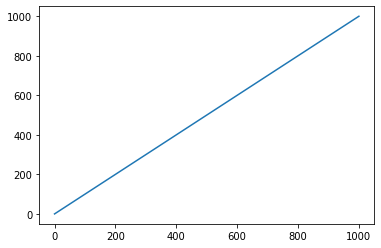

In [15]:
ns = sum([list(range(100*i, 100*(i+1), i+1)) for i in range(10)], []) + \
     [1_000]
     #sum([list(range(1000*i, 1000*(i+1), (i+1)*10)) for i in range(1, 10)], []) + \
     #sum([list(range(10000*i, 10000*(i+1), (i+1)*100)) for i in range(1, 10)], []) + \
     
# #list(range(num_population))
costs_of_n = [cost_of_n(n) for n in ns]
sns.lineplot(x=ns, y=costs_of_n)
states = ns
num_states = len(states)
num_states

In [14]:
lookup = dict([(x, i) for i in range(num_states - 1) for x in range(states[i], states[i+1])] + [(num_population, len(states) - 1)])
def bucket_state_index(new_state):
    if new_state < 0:
        raise Exception('Cannot have negative case count')
    elif new_state in lookup:
        return lookup[new_state]
    else:
        return lookup[num_population]
list(lookup.items())[-10:]

[(991, 295),
 (992, 295),
 (993, 295),
 (994, 295),
 (995, 295),
 (996, 295),
 (997, 295),
 (998, 295),
 (999, 295),
 (1000, 296)]

In [15]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [16]:
find_nearest(states, 2329)

1000

In [17]:
def expected_new_state(current_state, action, imported_cases_per_step=imported_cases_per_step, **kwargs):
    r_effective = action
    current_cases = current_state
    
    fraction_susceptible = 1 # (num_population - current_cases) / num_population
    # TODO: may need better way to bound susceptible population,
    # to account for immunity
    # One option: fraction_susceptible = 1 always, and just bound new_state by num_population

    # Better solution: keep track of how many people are susceptible NOW, based on some immunity time
    expected_new_cases = (current_cases * r_effective) * fraction_susceptible + imported_cases_per_step

    return expected_new_cases

In [18]:
expected_new_state(2330, 2.0, imported_cases_per_step=0.25)

4660.25

In [39]:
def new_state_distribution(state, action, distr_family='poisson', **kwargs):
    # distr_family: 'poisson' or 'nbinom'
    lam = expected_new_state(state, action, **kwargs)
    
    if distr_family == 'poisson':
        return poisson(lam)
    elif distr_family == 'nbinom':
        r = 100000000000000.0
        p = lam / (r + lam)
        return nbinom(r, 1-p)
    
# mean = pr/(1-p)
# = (r(lam)/(r+lam))/(r/(r+lam))
# = r*lam/r
# = lam

In [40]:
distribution = new_state_distribution(2330, 2.0, distr_family='nbinom')
distribution.mean(), distribution.var(), distribution.median()

(4660.516417231975, 4660.516417449178, 4660.0)

In [41]:
distribution = new_state_distribution(2330, 2.0, distr_family='poisson')
distribution.mean(), distribution.var(), distribution.median()

(4660.5, 4660.5, 4660.0)

In [16]:
distribution.cdf(4750) - distribution.cdf(4700)

0.18443092046258014

In [17]:
def bucketed_distribution(distribution, states):
    probs = np.zeros_like(states, dtype=float)
    for state_idx in range(num_states - 1):
        low_state = states[state_idx]
        high_state = states[state_idx + 1]
        probs[state_idx] = (distribution.cdf(high_state) - distribution.cdf(low_state))
    probs[num_states - 1] = 1 - distribution.cdf(states[num_states - 1])
    return probs

In [18]:
bucket_distr = bucketed_distribution(distribution, states)
[bucket_distr[bucket_state_index(x)] for x in [4500, 4550, 4600, 4650, 4700, 4750, 4800]]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

In [19]:
def transition_probabilities(distr_family='nbinom', **kwargs):
    transition_probs = np.zeros((num_states, num_actions, num_states))

    for state_idx in tqdm(range(num_states)):
        for action_idx in range(num_actions):
            distribution = new_state_distribution(states[state_idx], actions[action_idx], distr_family=distr_family, **kwargs)
            bucket_distr = bucketed_distribution(distribution, states)
            transition_probs[state_idx, action_idx] = bucket_distr
            #print(len(bucket_distr))
            
    return transition_probs

In [20]:
def reward(state, action, power=power, **kwargs):
    n = state
    r_effective = action
    return -cost_of_n(n, **kwargs) - cost_of_r(r_effective, **kwargs)  # should this be cost_of_n(new_state)?

In [21]:
def step(state_idx, action_idx):
    # state: number of current cases (discretized)
    # action: value of R_effective to set (discretized)
    # return: new_state, reward
    
    distr = new_state_distribution(states[state_idx], actions[action_idx])
    new_state = distr.rvs()
    
    # TODO: change to an actual expectation
    # ensure number of infected people does not exceed entire population
    new_state = min(new_state, num_population)
    new_state_idx = bucket_state_index(new_state)  # discretized case count
    
    resulting_reward = reward(states[state_idx], actions[action_idx])
    
    return new_state_idx, resulting_reward

In [22]:
state_idx = bucket_state_index(322)
print(f'original state: {states[state_idx]}')

action_idx = 2
print(f'action: {actions[action_idx]}')

new_state_idx, resulting_reward = step(state_idx, action_idx)
print('new state: ', states[new_state_idx])
print('reward : ', resulting_reward)

original state: 320
action: 0.3
new state:  85
reward :  -1415.111111111111


## Initial Conditions

## Value Iteration

In [23]:
def select_action(state_idx, state_values, transition_probs, **kwargs):
    rewards = np.zeros_like(actions, dtype=float)
    for action_idx in range(len(actions)):
        distr = new_state_distribution(states[state_idx], actions[action_idx])
        probs = transition_probs[state_idx, action_idx] # bucketed_distribution(distr, states)
        
        step_reward = reward(states[state_idx], actions[action_idx], **kwargs) 
        # TODO: in general, this should be coupled with the probability of reaching a given state. 
        # Here, we've made them independent, because we've made the reward be a function just of the state you're in and the action you take -- not of the next state you end up reaching
        
        rewards[action_idx] = (probs * (step_reward + state_values * discount)).sum()
    best_action_idx = rewards.argmax()
    return best_action_idx, rewards[best_action_idx] # action, lifetime value of taking this action

In [24]:
def state_value(state_idx, state_values, transition_probs, **kwargs):
    best_action, max_reward = select_action(state_idx, state_values, transition_probs, **kwargs)
    return max_reward # lifetime value of taking the best action from this state

In [25]:
def save_pickle(obj, file_name):
    with open(file_name, 'w') as f:
        s = pickle.dumps(obj, protocol=0)
        f.write(s.decode('latin-1'))

In [26]:
def load_pickle(file_name):
    with open(file_name, 'r') as f:
        s = f.read()
        obj = pickle.loads(s.encode('latin-1'))
    return obj

In [27]:
def compute_best_policy():

    epsilon = 1e-3

    # Load existing transition probabilities and policy table.
    # Compute in any missing values
    # Return best policies

    distr_family = 'nbinom'
    
    try:
        transition_probs = load_pickle(f'transition_probs_{distr_family}.pickle')
        print('Loaded transition_probs')
    except:
        transition_probs = {}

    try:
        policy_table = load_pickle('policy_table.pickle')
        print('Loaded policy_table')
    except:
        policy_table = {}


    for imported_cases_per_step in tqdm(imported_cases_per_step_range):
        # Try using cached transition probabilities:
        if imported_cases_per_step not in transition_probs:
            transition_probs[imported_cases_per_step] = transition_probabilities(imported_cases_per_step=imported_cases_per_step, distr_family=distr_family)
            save_pickle(transition_probs, 'transition_probs.pickle')
        else:
            print(f'transition_probs already computed for imported_cases_per_step = {imported_cases_per_step}')

        for power in tqdm(power_range):
            for scale_factor in tqdm(scale_factor_range):

                params_obj = {
                    'power': power,
                    'imported_cases_per_step': imported_cases_per_step,
                    'scale_factor': scale_factor
                }
                kwargs = params_obj
                params_key = tuple(params_obj.items())

                # Try using cached policy
                if params_key in params_obj:
                    print('policy already computed for {params_key}')
                    continue

                state_values = np.random.random(num_states) * -1000 - 1000
                best_action_idx = np.zeros_like(state_values)

                for i in tqdm(range(100)):
                    new_state_values = np.zeros_like(state_values, dtype=float)
                    for state_idx in range(num_states):
                        best_action_idx[state_idx], new_state_values[state_idx] = select_action(state_idx, state_values, transition_probs[imported_cases_per_step], **kwargs)
                    diffs = abs(state_values - new_state_values)
                    max_diff = diffs.max()
                    print(f'max_diff = {max_diff}')
                    state_values = new_state_values
                    if max_diff < epsilon:
                        print(f'max_diff: {max_diff} < {epsilon}')
                        break

                result_obj = {
                    'best_action_idx': best_action_idx,
                    'state_values': state_values
                }


                policy_table[params_key] = result_obj

                save_pickle(policy_table, 'policy_table.pickle')

    return policy_table

In [28]:
policy_table = compute_best_policy()

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]


  0%|          | 0/100 [00:00<?, ?it/s]

Loaded transition_probs
Loaded policy_table
transition_probs already computed for imported_cases_per_step = 0.0





  1%|          | 1/100 [00:02<04:08,  2.51s/it]

max_diff = 1363.7275873154986





  2%|▏         | 2/100 [00:05<04:05,  2.51s/it]

max_diff = 771.8796620665835





  3%|▎         | 3/100 [00:07<04:01,  2.49s/it]

max_diff = 483.3649854325504





  4%|▍         | 4/100 [00:09<03:58,  2.48s/it]

max_diff = 362.6971504287626





  5%|▌         | 5/100 [00:12<03:55,  2.48s/it]

max_diff = 276.4890254260772


  0%|          | 0/5 [00:14<?, ?it/s]


KeyboardInterrupt: 

## State Values

## Optimal Policies

In [63]:
policy_table = load_pickle('policy_table.pickle')

In [64]:
df = pd.DataFrame(columns=['power', 'imported_cases_per_step', 'scale_factor', 'case_count_n', 'best_action_r'])
df

,power,imported_cases_per_step,scale_factor,case_count_n,best_action_r


In [65]:
for key in policy_table:
    best_action_idx = policy_table[key]['best_action_idx']
    for (state_idx, action_idx) in enumerate(best_action_idx):
        key_dict = dict(key)
        key_dict['case_count_n'] = states[state_idx]
        key_dict['best_action_r'] = actions[int(action_idx)]
        df.loc[len(df)] = key_dict

In [69]:
df.to_csv('policy_table.csv')

In [122]:
df[df['power'] == 1][df['imported_cases_per_step'] == 0][df['scale_factor'] == 100]

<ipython-input-122-ea931ece3d65>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df['power'] == 1][df['imported_cases_per_step'] == 0][df['scale_factor'] == 100]


,power,imported_cases_per_step,scale_factor,case_count_n,best_action_r
1,1,0,100,0,0.1
2,1,0,100,1,1.1
3,1,0,100,2,1
4,1,0,100,3,0.9
5,1,0,100,4,0.9
...,...,...,...,...,...
293,1,0,100,960,0.4
294,1,0,100,970,0.4
295,1,0,100,980,0.4
296,1,0,100,990,0.4


### Policy Plots...

In [59]:
def plot_policy(best_action_idx):
    ax = sns.barplot(list(range(num_states)),
                [actions[int(best_action_idx[n])] for n in range(num_states)])
    # ax.set(xlabel='common xlabel', ylabel='common ylabel')
    ax.set_xticks(range(int(len(states) / 1)))
    ax.set_xticklabels([state for i, state in enumerate(states) if i % 1 == 0])
    plt.show()

def print_policy_short(best_action_idx):
    d1 = {
        states[state_idx]: actions[int(action_idx)]
        for state_idx, action_idx in enumerate(best_action_idx)
        if (state_idx < 10)
    }
    d2 = {
        states[state_idx]: actions[int(action_idx)]
        for state_idx, action_idx in enumerate(best_action_idx)
        if (state_idx > len(best_action_idx) - 10)
    }
    print(d1)
    print('...')
    print(d2)

(('power', 1.0), ('imported_cases_per_step', 0.0), ('scale_factor', 100))
{0: 0.1, 1: 1.1, 2: 1.0, 3: 0.9, 4: 0.9, 5: 0.8, 6: 0.8, 7: 0.8, 8: 0.8, 9: 0.8}
...
{920: 0.4, 930: 0.4, 940: 0.4, 950: 0.4, 960: 0.4, 970: 0.4, 980: 0.4, 990: 0.4, 1000: 0.4}


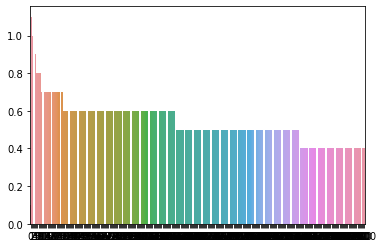

(('power', 1.0), ('imported_cases_per_step', 0.0), ('scale_factor', 500))
{0: 0.1, 1: 1.1, 2: 1.1, 3: 1.0, 4: 0.9, 5: 0.9, 6: 0.8, 7: 0.8, 8: 0.8, 9: 0.8}
...
{920: 0.5, 930: 0.5, 940: 0.5, 950: 0.5, 960: 0.5, 970: 0.5, 980: 0.5, 990: 0.5, 1000: 0.5}


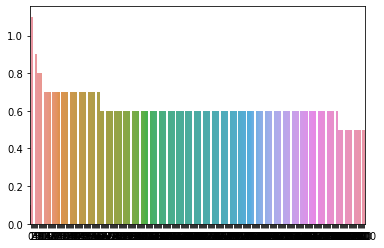

(('power', 1.0), ('imported_cases_per_step', 0.0), ('scale_factor', 1000))
{0: 0.1, 1: 1.5, 2: 1.1, 3: 1.0, 4: 0.9, 5: 0.9, 6: 0.8, 7: 0.8, 8: 0.8, 9: 0.8}
...
{920: 0.6, 930: 0.6, 940: 0.6, 950: 0.6, 960: 0.6, 970: 0.6, 980: 0.6, 990: 0.6, 1000: 0.6}


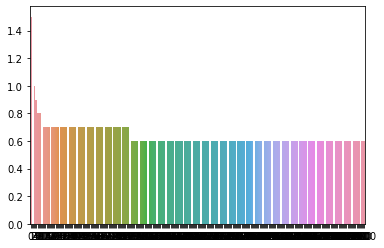

(('power', 1.5), ('imported_cases_per_step', 0.0), ('scale_factor', 100))
{0: 0.1, 1: 1.1, 2: 1.0, 3: 0.9, 4: 0.9, 5: 0.8, 6: 0.8, 7: 0.8, 8: 0.8, 9: 0.8}
...
{920: 0.4, 930: 0.4, 940: 0.4, 950: 0.4, 960: 0.4, 970: 0.4, 980: 0.4, 990: 0.4, 1000: 0.4}


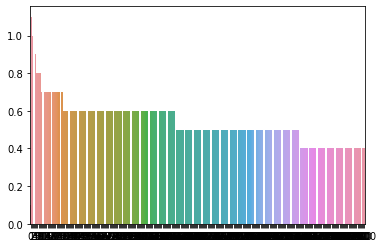

(('power', 1.5), ('imported_cases_per_step', 0.0), ('scale_factor', 500))
{0: 0.1, 1: 1.1, 2: 1.1, 3: 1.0, 4: 0.9, 5: 0.9, 6: 0.8, 7: 0.8, 8: 0.8, 9: 0.8}
...
{920: 0.5, 930: 0.5, 940: 0.5, 950: 0.5, 960: 0.5, 970: 0.5, 980: 0.5, 990: 0.5, 1000: 0.5}


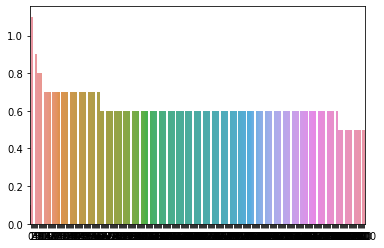

(('power', 1.5), ('imported_cases_per_step', 0.0), ('scale_factor', 1000))
{0: 0.1, 1: 1.5, 2: 1.1, 3: 1.0, 4: 0.9, 5: 0.9, 6: 0.8, 7: 0.8, 8: 0.8, 9: 0.8}
...
{920: 0.6, 930: 0.6, 940: 0.6, 950: 0.6, 960: 0.6, 970: 0.6, 980: 0.6, 990: 0.6, 1000: 0.6}


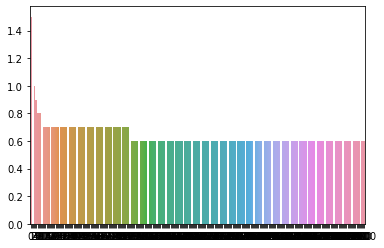

(('power', 2.0), ('imported_cases_per_step', 0.0), ('scale_factor', 100))
{0: 0.1, 1: 1.1, 2: 1.0, 3: 0.9, 4: 0.9, 5: 0.8, 6: 0.8, 7: 0.8, 8: 0.8, 9: 0.8}
...
{920: 0.4, 930: 0.4, 940: 0.4, 950: 0.4, 960: 0.4, 970: 0.4, 980: 0.4, 990: 0.4, 1000: 0.4}


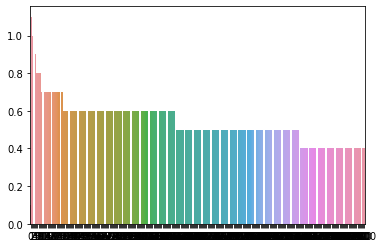

(('power', 2.0), ('imported_cases_per_step', 0.0), ('scale_factor', 500))
{0: 0.1, 1: 1.1, 2: 1.1, 3: 1.0, 4: 0.9, 5: 0.9, 6: 0.8, 7: 0.8, 8: 0.8, 9: 0.8}
...
{920: 0.5, 930: 0.5, 940: 0.5, 950: 0.5, 960: 0.5, 970: 0.5, 980: 0.5, 990: 0.5, 1000: 0.5}


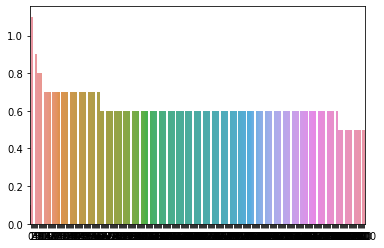

(('power', 2.0), ('imported_cases_per_step', 0.0), ('scale_factor', 1000))
{0: 0.1, 1: 1.5, 2: 1.1, 3: 1.0, 4: 0.9, 5: 0.9, 6: 0.8, 7: 0.8, 8: 0.8, 9: 0.8}
...
{920: 0.6, 930: 0.6, 940: 0.6, 950: 0.6, 960: 0.6, 970: 0.6, 980: 0.6, 990: 0.6, 1000: 0.6}


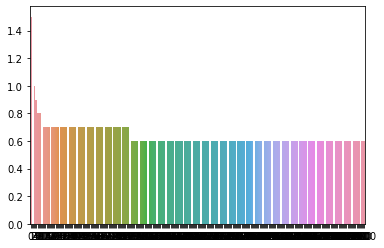

(('power', 2.5), ('imported_cases_per_step', 0.0), ('scale_factor', 100))
{0: 0.1, 1: 1.1, 2: 1.0, 3: 0.9, 4: 0.9, 5: 0.8, 6: 0.8, 7: 0.8, 8: 0.8, 9: 0.8}
...
{920: 0.4, 930: 0.4, 940: 0.4, 950: 0.4, 960: 0.4, 970: 0.4, 980: 0.4, 990: 0.4, 1000: 0.4}


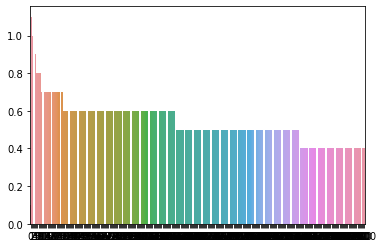

(('power', 2.5), ('imported_cases_per_step', 0.0), ('scale_factor', 500))
{0: 0.1, 1: 1.1, 2: 1.1, 3: 1.0, 4: 0.9, 5: 0.9, 6: 0.8, 7: 0.8, 8: 0.8, 9: 0.8}
...
{920: 0.5, 930: 0.5, 940: 0.5, 950: 0.5, 960: 0.5, 970: 0.5, 980: 0.5, 990: 0.5, 1000: 0.5}


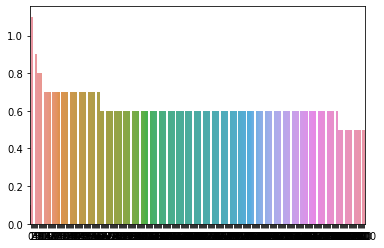

(('power', 2.5), ('imported_cases_per_step', 0.0), ('scale_factor', 1000))
{0: 0.1, 1: 1.5, 2: 1.1, 3: 1.0, 4: 0.9, 5: 0.9, 6: 0.8, 7: 0.8, 8: 0.8, 9: 0.8}
...
{920: 0.6, 930: 0.6, 940: 0.6, 950: 0.6, 960: 0.6, 970: 0.6, 980: 0.6, 990: 0.6, 1000: 0.6}


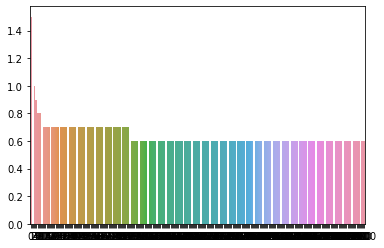

(('power', 1.0), ('imported_cases_per_step', 0.2), ('scale_factor', 100))
{0: 2.5, 1: 1.1, 2: 1.0, 3: 0.9, 4: 0.9, 5: 0.8, 6: 0.8, 7: 0.8, 8: 0.7, 9: 0.7}
...
{920: 0.4, 930: 0.4, 940: 0.4, 950: 0.4, 960: 0.4, 970: 0.4, 980: 0.4, 990: 0.4, 1000: 0.4}


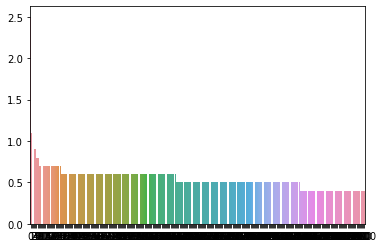

(('power', 1.0), ('imported_cases_per_step', 0.2), ('scale_factor', 500))
{0: 2.5, 1: 1.1, 2: 1.0, 3: 0.9, 4: 0.9, 5: 0.8, 6: 0.8, 7: 0.8, 8: 0.8, 9: 0.7}
...
{920: 0.5, 930: 0.5, 940: 0.5, 950: 0.5, 960: 0.5, 970: 0.5, 980: 0.5, 990: 0.5, 1000: 0.5}


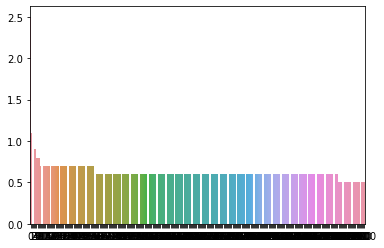

(('power', 1.0), ('imported_cases_per_step', 0.2), ('scale_factor', 1000))
{0: 2.5, 1: 1.1, 2: 1.0, 3: 0.9, 4: 0.9, 5: 0.8, 6: 0.8, 7: 0.8, 8: 0.8, 9: 0.7}
...
{920: 0.6, 930: 0.6, 940: 0.6, 950: 0.6, 960: 0.6, 970: 0.6, 980: 0.6, 990: 0.6, 1000: 0.6}


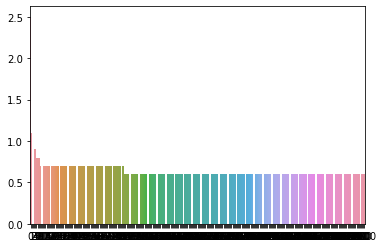

(('power', 1.5), ('imported_cases_per_step', 0.2), ('scale_factor', 100))
{0: 2.5, 1: 1.1, 2: 1.0, 3: 0.9, 4: 0.9, 5: 0.8, 6: 0.8, 7: 0.8, 8: 0.7, 9: 0.7}
...
{920: 0.4, 930: 0.4, 940: 0.4, 950: 0.4, 960: 0.4, 970: 0.4, 980: 0.4, 990: 0.4, 1000: 0.4}


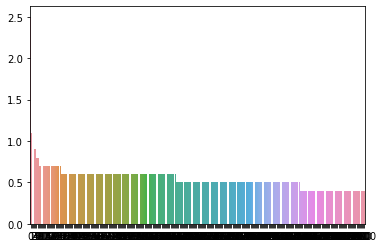

(('power', 1.5), ('imported_cases_per_step', 0.2), ('scale_factor', 500))
{0: 2.5, 1: 1.1, 2: 1.0, 3: 0.9, 4: 0.9, 5: 0.8, 6: 0.8, 7: 0.8, 8: 0.8, 9: 0.7}
...
{920: 0.5, 930: 0.5, 940: 0.5, 950: 0.5, 960: 0.5, 970: 0.5, 980: 0.5, 990: 0.5, 1000: 0.5}


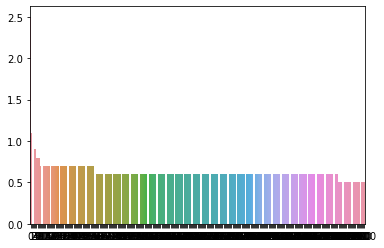

(('power', 1.5), ('imported_cases_per_step', 0.2), ('scale_factor', 1000))
{0: 2.5, 1: 1.1, 2: 1.0, 3: 0.9, 4: 0.9, 5: 0.8, 6: 0.8, 7: 0.8, 8: 0.8, 9: 0.7}
...
{920: 0.6, 930: 0.6, 940: 0.6, 950: 0.6, 960: 0.6, 970: 0.6, 980: 0.6, 990: 0.6, 1000: 0.6}


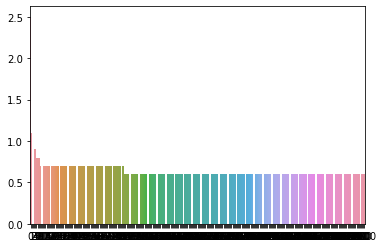

(('power', 2.0), ('imported_cases_per_step', 0.2), ('scale_factor', 100))
{0: 2.5, 1: 1.1, 2: 1.0, 3: 0.9, 4: 0.9, 5: 0.8, 6: 0.8, 7: 0.8, 8: 0.7, 9: 0.7}
...
{920: 0.4, 930: 0.4, 940: 0.4, 950: 0.4, 960: 0.4, 970: 0.4, 980: 0.4, 990: 0.4, 1000: 0.4}


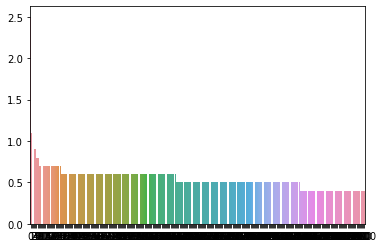

(('power', 2.0), ('imported_cases_per_step', 0.2), ('scale_factor', 500))
{0: 2.5, 1: 1.1, 2: 1.0, 3: 0.9, 4: 0.9, 5: 0.8, 6: 0.8, 7: 0.8, 8: 0.8, 9: 0.7}
...
{920: 0.5, 930: 0.5, 940: 0.5, 950: 0.5, 960: 0.5, 970: 0.5, 980: 0.5, 990: 0.5, 1000: 0.5}


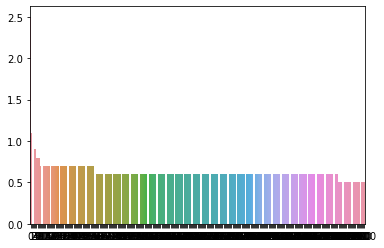

(('power', 2.0), ('imported_cases_per_step', 0.2), ('scale_factor', 1000))
{0: 2.5, 1: 1.1, 2: 1.0, 3: 0.9, 4: 0.9, 5: 0.8, 6: 0.8, 7: 0.8, 8: 0.8, 9: 0.7}
...
{920: 0.6, 930: 0.6, 940: 0.6, 950: 0.6, 960: 0.6, 970: 0.6, 980: 0.6, 990: 0.6, 1000: 0.6}


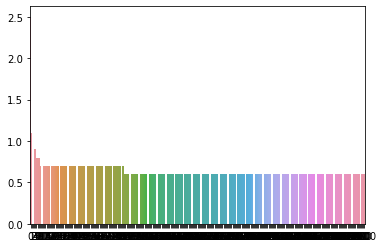

(('power', 2.5), ('imported_cases_per_step', 0.2), ('scale_factor', 100))
{0: 2.5, 1: 1.1, 2: 1.0, 3: 0.9, 4: 0.9, 5: 0.8, 6: 0.8, 7: 0.8, 8: 0.7, 9: 0.7}
...
{920: 0.4, 930: 0.4, 940: 0.4, 950: 0.4, 960: 0.4, 970: 0.4, 980: 0.4, 990: 0.4, 1000: 0.4}


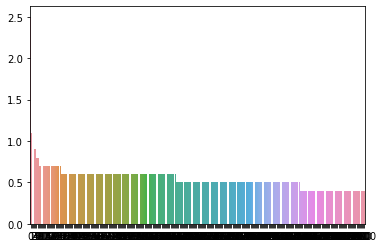

(('power', 2.5), ('imported_cases_per_step', 0.2), ('scale_factor', 500))
{0: 2.5, 1: 1.1, 2: 1.0, 3: 0.9, 4: 0.9, 5: 0.8, 6: 0.8, 7: 0.8, 8: 0.8, 9: 0.7}
...
{920: 0.5, 930: 0.5, 940: 0.5, 950: 0.5, 960: 0.5, 970: 0.5, 980: 0.5, 990: 0.5, 1000: 0.5}


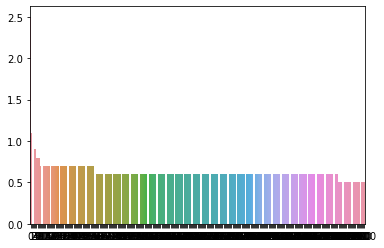

(('power', 2.5), ('imported_cases_per_step', 0.2), ('scale_factor', 1000))
{0: 2.5, 1: 1.1, 2: 1.0, 3: 0.9, 4: 0.9, 5: 0.8, 6: 0.8, 7: 0.8, 8: 0.8, 9: 0.7}
...
{920: 0.6, 930: 0.6, 940: 0.6, 950: 0.6, 960: 0.6, 970: 0.6, 980: 0.6, 990: 0.6, 1000: 0.6}


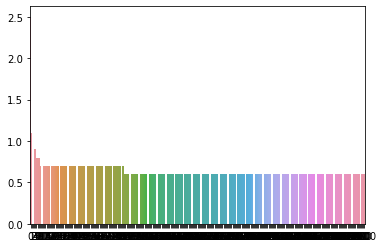

(('power', 1.0), ('imported_cases_per_step', 0.4), ('scale_factor', 100))
{0: 2.5, 1: 1.1, 2: 0.9, 3: 0.9, 4: 0.8, 5: 0.8, 6: 0.8, 7: 0.7, 8: 0.7, 9: 0.7}
...
{920: 0.4, 930: 0.4, 940: 0.4, 950: 0.4, 960: 0.4, 970: 0.4, 980: 0.4, 990: 0.4, 1000: 0.4}


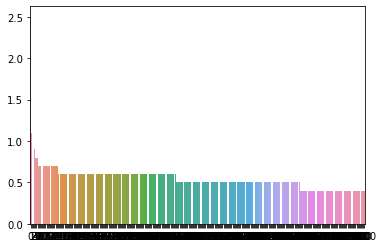

(('power', 1.0), ('imported_cases_per_step', 0.4), ('scale_factor', 500))
{0: 2.5, 1: 1.1, 2: 1.0, 3: 0.9, 4: 0.8, 5: 0.8, 6: 0.8, 7: 0.8, 8: 0.7, 9: 0.7}
...
{920: 0.5, 930: 0.5, 940: 0.5, 950: 0.5, 960: 0.5, 970: 0.5, 980: 0.5, 990: 0.5, 1000: 0.5}


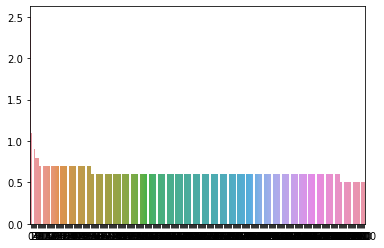

(('power', 1.0), ('imported_cases_per_step', 0.4), ('scale_factor', 1000))
{0: 2.5, 1: 1.1, 2: 1.0, 3: 0.9, 4: 0.8, 5: 0.8, 6: 0.8, 7: 0.8, 8: 0.7, 9: 0.7}
...
{920: 0.6, 930: 0.6, 940: 0.6, 950: 0.6, 960: 0.6, 970: 0.6, 980: 0.6, 990: 0.6, 1000: 0.6}


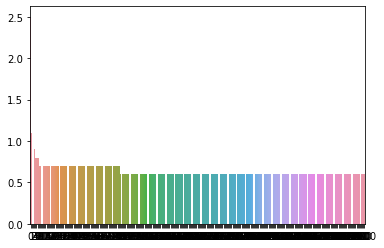

(('power', 1.5), ('imported_cases_per_step', 0.4), ('scale_factor', 100))
{0: 2.5, 1: 1.1, 2: 0.9, 3: 0.9, 4: 0.8, 5: 0.8, 6: 0.8, 7: 0.7, 8: 0.7, 9: 0.7}
...
{920: 0.4, 930: 0.4, 940: 0.4, 950: 0.4, 960: 0.4, 970: 0.4, 980: 0.4, 990: 0.4, 1000: 0.4}


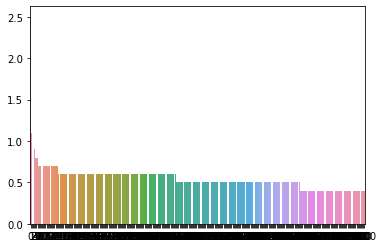

(('power', 1.5), ('imported_cases_per_step', 0.4), ('scale_factor', 500))
{0: 2.5, 1: 1.1, 2: 1.0, 3: 0.9, 4: 0.8, 5: 0.8, 6: 0.8, 7: 0.8, 8: 0.7, 9: 0.7}
...
{920: 0.5, 930: 0.5, 940: 0.5, 950: 0.5, 960: 0.5, 970: 0.5, 980: 0.5, 990: 0.5, 1000: 0.5}


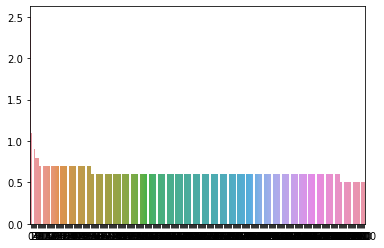

(('power', 1.5), ('imported_cases_per_step', 0.4), ('scale_factor', 1000))
{0: 2.5, 1: 1.1, 2: 1.0, 3: 0.9, 4: 0.8, 5: 0.8, 6: 0.8, 7: 0.8, 8: 0.7, 9: 0.7}
...
{920: 0.6, 930: 0.6, 940: 0.6, 950: 0.6, 960: 0.6, 970: 0.6, 980: 0.6, 990: 0.6, 1000: 0.6}


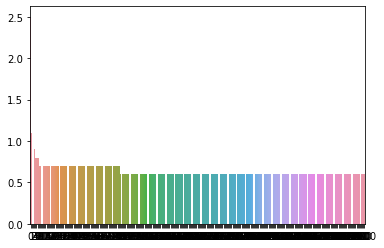

(('power', 2.0), ('imported_cases_per_step', 0.4), ('scale_factor', 100))
{0: 2.5, 1: 1.1, 2: 0.9, 3: 0.9, 4: 0.8, 5: 0.8, 6: 0.8, 7: 0.7, 8: 0.7, 9: 0.7}
...
{920: 0.4, 930: 0.4, 940: 0.4, 950: 0.4, 960: 0.4, 970: 0.4, 980: 0.4, 990: 0.4, 1000: 0.4}


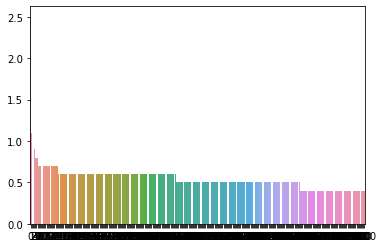

(('power', 2.0), ('imported_cases_per_step', 0.4), ('scale_factor', 500))
{0: 2.5, 1: 1.1, 2: 1.0, 3: 0.9, 4: 0.8, 5: 0.8, 6: 0.8, 7: 0.8, 8: 0.7, 9: 0.7}
...
{920: 0.5, 930: 0.5, 940: 0.5, 950: 0.5, 960: 0.5, 970: 0.5, 980: 0.5, 990: 0.5, 1000: 0.5}


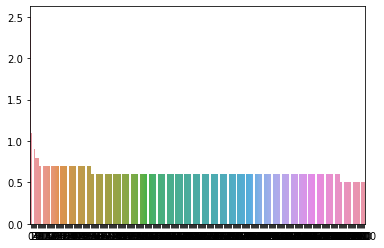

(('power', 2.0), ('imported_cases_per_step', 0.4), ('scale_factor', 1000))
{0: 2.5, 1: 1.1, 2: 1.0, 3: 0.9, 4: 0.8, 5: 0.8, 6: 0.8, 7: 0.8, 8: 0.7, 9: 0.7}
...
{920: 0.6, 930: 0.6, 940: 0.6, 950: 0.6, 960: 0.6, 970: 0.6, 980: 0.6, 990: 0.6, 1000: 0.6}


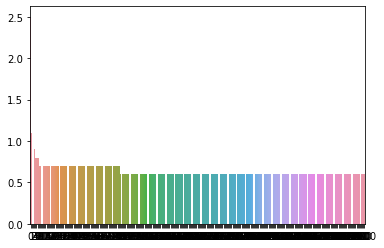

(('power', 2.5), ('imported_cases_per_step', 0.4), ('scale_factor', 100))
{0: 2.5, 1: 1.1, 2: 0.9, 3: 0.9, 4: 0.8, 5: 0.8, 6: 0.8, 7: 0.7, 8: 0.7, 9: 0.7}
...
{920: 0.4, 930: 0.4, 940: 0.4, 950: 0.4, 960: 0.4, 970: 0.4, 980: 0.4, 990: 0.4, 1000: 0.4}


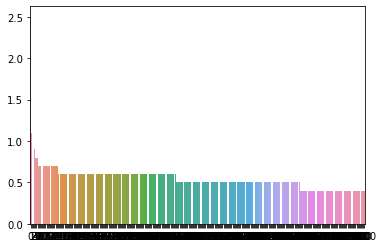

(('power', 2.5), ('imported_cases_per_step', 0.4), ('scale_factor', 500))
{0: 2.5, 1: 1.1, 2: 1.0, 3: 0.9, 4: 0.8, 5: 0.8, 6: 0.8, 7: 0.8, 8: 0.7, 9: 0.7}
...
{920: 0.5, 930: 0.5, 940: 0.5, 950: 0.5, 960: 0.5, 970: 0.5, 980: 0.5, 990: 0.5, 1000: 0.5}


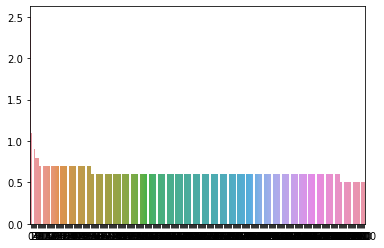

(('power', 2.5), ('imported_cases_per_step', 0.4), ('scale_factor', 1000))
{0: 2.5, 1: 1.1, 2: 1.0, 3: 0.9, 4: 0.8, 5: 0.8, 6: 0.8, 7: 0.8, 8: 0.7, 9: 0.7}
...
{920: 0.6, 930: 0.6, 940: 0.6, 950: 0.6, 960: 0.6, 970: 0.6, 980: 0.6, 990: 0.6, 1000: 0.6}


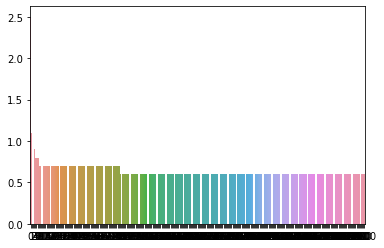

(('power', 1.0), ('imported_cases_per_step', 0.6000000000000001), ('scale_factor', 100))
{0: 2.5, 1: 1.1, 2: 0.9, 3: 0.8, 4: 0.8, 5: 0.8, 6: 0.7, 7: 0.7, 8: 0.7, 9: 0.7}
...
{920: 0.4, 930: 0.4, 940: 0.4, 950: 0.4, 960: 0.4, 970: 0.4, 980: 0.4, 990: 0.4, 1000: 0.4}


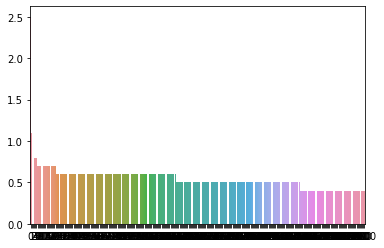

(('power', 1.0), ('imported_cases_per_step', 0.6000000000000001), ('scale_factor', 500))
{0: 2.5, 1: 1.1, 2: 0.9, 3: 0.8, 4: 0.8, 5: 0.8, 6: 0.8, 7: 0.7, 8: 0.7, 9: 0.7}
...
{920: 0.5, 930: 0.5, 940: 0.5, 950: 0.5, 960: 0.5, 970: 0.5, 980: 0.5, 990: 0.5, 1000: 0.5}


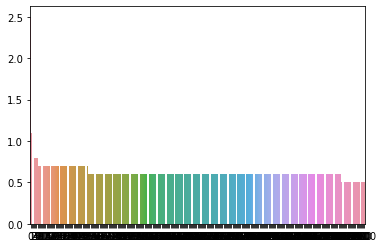

(('power', 1.0), ('imported_cases_per_step', 0.6000000000000001), ('scale_factor', 1000))
{0: 2.5, 1: 1.1, 2: 0.9, 3: 0.8, 4: 0.8, 5: 0.8, 6: 0.8, 7: 0.7, 8: 0.7, 9: 0.7}
...
{920: 0.6, 930: 0.6, 940: 0.6, 950: 0.6, 960: 0.6, 970: 0.6, 980: 0.6, 990: 0.6, 1000: 0.6}


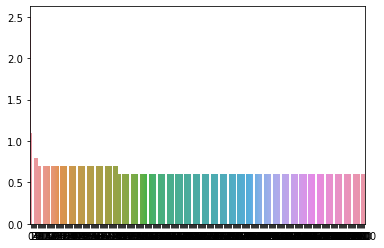

(('power', 1.5), ('imported_cases_per_step', 0.6000000000000001), ('scale_factor', 100))
{0: 2.5, 1: 1.1, 2: 0.9, 3: 0.8, 4: 0.8, 5: 0.8, 6: 0.7, 7: 0.7, 8: 0.7, 9: 0.7}
...
{920: 0.4, 930: 0.4, 940: 0.4, 950: 0.4, 960: 0.4, 970: 0.4, 980: 0.4, 990: 0.4, 1000: 0.4}


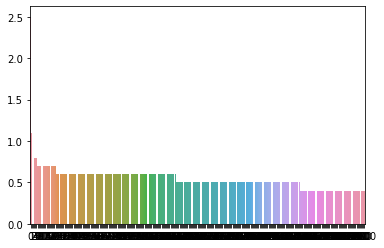

(('power', 1.5), ('imported_cases_per_step', 0.6000000000000001), ('scale_factor', 500))
{0: 2.5, 1: 1.1, 2: 0.9, 3: 0.8, 4: 0.8, 5: 0.8, 6: 0.8, 7: 0.7, 8: 0.7, 9: 0.7}
...
{920: 0.5, 930: 0.5, 940: 0.5, 950: 0.5, 960: 0.5, 970: 0.5, 980: 0.5, 990: 0.5, 1000: 0.5}


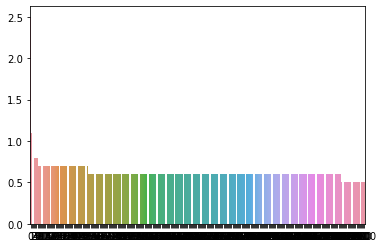

(('power', 1.5), ('imported_cases_per_step', 0.6000000000000001), ('scale_factor', 1000))
{0: 2.5, 1: 1.1, 2: 0.9, 3: 0.8, 4: 0.8, 5: 0.8, 6: 0.8, 7: 0.7, 8: 0.7, 9: 0.7}
...
{920: 0.6, 930: 0.6, 940: 0.6, 950: 0.6, 960: 0.6, 970: 0.6, 980: 0.6, 990: 0.6, 1000: 0.6}


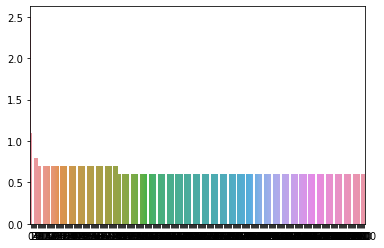

(('power', 2.0), ('imported_cases_per_step', 0.6000000000000001), ('scale_factor', 100))
{0: 2.5, 1: 1.1, 2: 0.9, 3: 0.8, 4: 0.8, 5: 0.8, 6: 0.7, 7: 0.7, 8: 0.7, 9: 0.7}
...
{920: 0.4, 930: 0.4, 940: 0.4, 950: 0.4, 960: 0.4, 970: 0.4, 980: 0.4, 990: 0.4, 1000: 0.4}


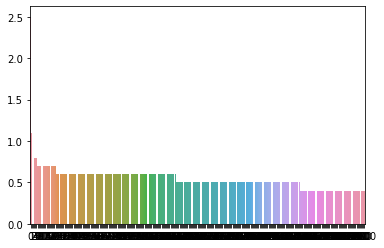

(('power', 2.0), ('imported_cases_per_step', 0.6000000000000001), ('scale_factor', 500))
{0: 2.5, 1: 1.1, 2: 0.9, 3: 0.8, 4: 0.8, 5: 0.8, 6: 0.8, 7: 0.7, 8: 0.7, 9: 0.7}
...
{920: 0.5, 930: 0.5, 940: 0.5, 950: 0.5, 960: 0.5, 970: 0.5, 980: 0.5, 990: 0.5, 1000: 0.5}


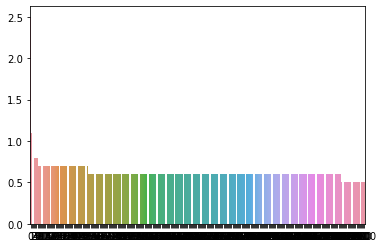

(('power', 2.0), ('imported_cases_per_step', 0.6000000000000001), ('scale_factor', 1000))
{0: 2.5, 1: 1.1, 2: 0.9, 3: 0.8, 4: 0.8, 5: 0.8, 6: 0.8, 7: 0.7, 8: 0.7, 9: 0.7}
...
{920: 0.6, 930: 0.6, 940: 0.6, 950: 0.6, 960: 0.6, 970: 0.6, 980: 0.6, 990: 0.6, 1000: 0.6}


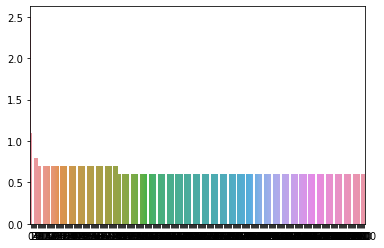

(('power', 2.5), ('imported_cases_per_step', 0.6000000000000001), ('scale_factor', 100))
{0: 2.5, 1: 1.1, 2: 0.9, 3: 0.8, 4: 0.8, 5: 0.8, 6: 0.7, 7: 0.7, 8: 0.7, 9: 0.7}
...
{920: 0.4, 930: 0.4, 940: 0.4, 950: 0.4, 960: 0.4, 970: 0.4, 980: 0.4, 990: 0.4, 1000: 0.4}


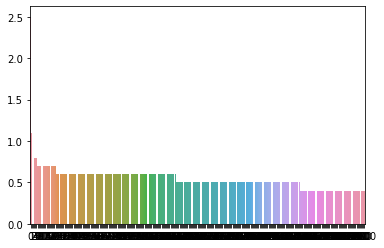

(('power', 2.5), ('imported_cases_per_step', 0.6000000000000001), ('scale_factor', 500))
{0: 2.5, 1: 1.1, 2: 0.9, 3: 0.8, 4: 0.8, 5: 0.8, 6: 0.8, 7: 0.7, 8: 0.7, 9: 0.7}
...
{920: 0.5, 930: 0.5, 940: 0.5, 950: 0.5, 960: 0.5, 970: 0.5, 980: 0.5, 990: 0.5, 1000: 0.5}


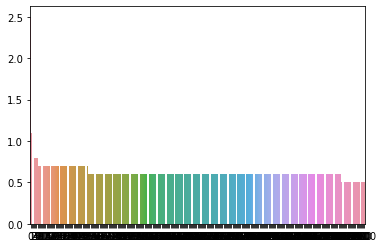

(('power', 2.5), ('imported_cases_per_step', 0.6000000000000001), ('scale_factor', 1000))
{0: 2.5, 1: 1.1, 2: 0.9, 3: 0.8, 4: 0.8, 5: 0.8, 6: 0.8, 7: 0.7, 8: 0.7, 9: 0.7}
...
{920: 0.6, 930: 0.6, 940: 0.6, 950: 0.6, 960: 0.6, 970: 0.6, 980: 0.6, 990: 0.6, 1000: 0.6}


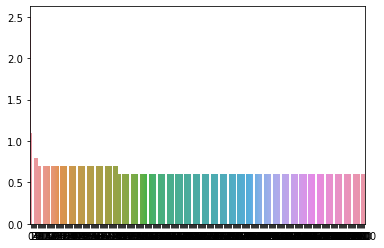

(('power', 1.0), ('imported_cases_per_step', 0.8), ('scale_factor', 100))
{0: 2.5, 1: 1.0, 2: 0.9, 3: 0.8, 4: 0.8, 5: 0.7, 6: 0.7, 7: 0.7, 8: 0.7, 9: 0.7}
...
{920: 0.4, 930: 0.4, 940: 0.4, 950: 0.4, 960: 0.4, 970: 0.4, 980: 0.4, 990: 0.4, 1000: 0.4}


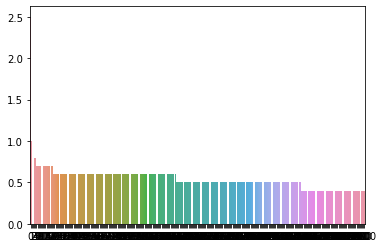

(('power', 1.0), ('imported_cases_per_step', 0.8), ('scale_factor', 500))
{0: 2.5, 1: 1.0, 2: 0.9, 3: 0.8, 4: 0.8, 5: 0.7, 6: 0.7, 7: 0.7, 8: 0.7, 9: 0.7}
...
{920: 0.5, 930: 0.5, 940: 0.5, 950: 0.5, 960: 0.5, 970: 0.5, 980: 0.5, 990: 0.5, 1000: 0.5}


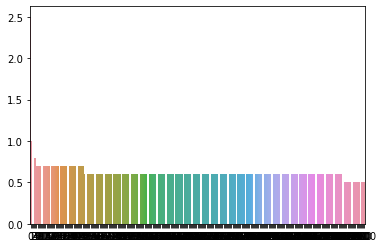

(('power', 1.0), ('imported_cases_per_step', 0.8), ('scale_factor', 1000))
{0: 2.5, 1: 1.0, 2: 0.9, 3: 0.8, 4: 0.8, 5: 0.7, 6: 0.7, 7: 0.7, 8: 0.7, 9: 0.7}
...
{920: 0.6, 930: 0.6, 940: 0.6, 950: 0.6, 960: 0.6, 970: 0.6, 980: 0.6, 990: 0.6, 1000: 0.6}


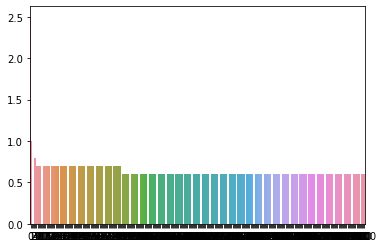

(('power', 1.5), ('imported_cases_per_step', 0.8), ('scale_factor', 100))
{0: 2.5, 1: 1.0, 2: 0.9, 3: 0.8, 4: 0.8, 5: 0.7, 6: 0.7, 7: 0.7, 8: 0.7, 9: 0.7}
...
{920: 0.4, 930: 0.4, 940: 0.4, 950: 0.4, 960: 0.4, 970: 0.4, 980: 0.4, 990: 0.4, 1000: 0.4}


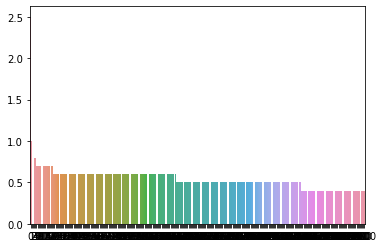

(('power', 1.5), ('imported_cases_per_step', 0.8), ('scale_factor', 500))
{0: 2.5, 1: 1.0, 2: 0.9, 3: 0.8, 4: 0.8, 5: 0.7, 6: 0.7, 7: 0.7, 8: 0.7, 9: 0.7}
...
{920: 0.5, 930: 0.5, 940: 0.5, 950: 0.5, 960: 0.5, 970: 0.5, 980: 0.5, 990: 0.5, 1000: 0.5}


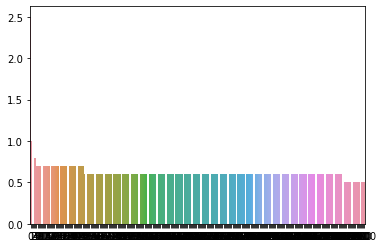

(('power', 1.5), ('imported_cases_per_step', 0.8), ('scale_factor', 1000))
{0: 2.5, 1: 1.0, 2: 0.9, 3: 0.8, 4: 0.8, 5: 0.7, 6: 0.7, 7: 0.7, 8: 0.7, 9: 0.7}
...
{920: 0.6, 930: 0.6, 940: 0.6, 950: 0.6, 960: 0.6, 970: 0.6, 980: 0.6, 990: 0.6, 1000: 0.6}


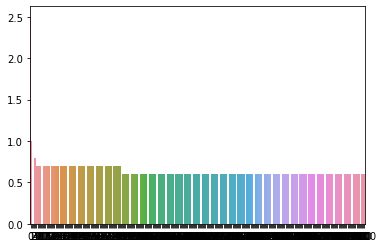

(('power', 2.0), ('imported_cases_per_step', 0.8), ('scale_factor', 100))
{0: 2.5, 1: 1.0, 2: 0.9, 3: 0.8, 4: 0.8, 5: 0.7, 6: 0.7, 7: 0.7, 8: 0.7, 9: 0.7}
...
{920: 0.4, 930: 0.4, 940: 0.4, 950: 0.4, 960: 0.4, 970: 0.4, 980: 0.4, 990: 0.4, 1000: 0.4}


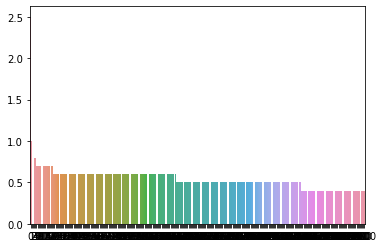

(('power', 2.0), ('imported_cases_per_step', 0.8), ('scale_factor', 500))
{0: 2.5, 1: 1.0, 2: 0.9, 3: 0.8, 4: 0.8, 5: 0.7, 6: 0.7, 7: 0.7, 8: 0.7, 9: 0.7}
...
{920: 0.5, 930: 0.5, 940: 0.5, 950: 0.5, 960: 0.5, 970: 0.5, 980: 0.5, 990: 0.5, 1000: 0.5}


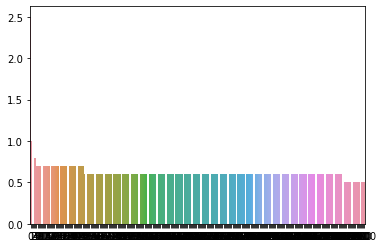

(('power', 2.0), ('imported_cases_per_step', 0.8), ('scale_factor', 1000))
{0: 2.5, 1: 1.0, 2: 0.9, 3: 0.8, 4: 0.8, 5: 0.7, 6: 0.7, 7: 0.7, 8: 0.7, 9: 0.7}
...
{920: 0.6, 930: 0.6, 940: 0.6, 950: 0.6, 960: 0.6, 970: 0.6, 980: 0.6, 990: 0.6, 1000: 0.6}


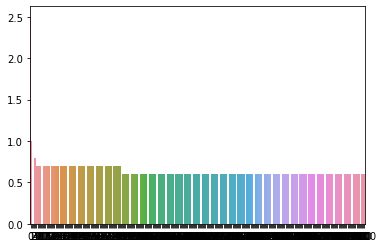

(('power', 2.5), ('imported_cases_per_step', 0.8), ('scale_factor', 100))
{0: 2.5, 1: 1.0, 2: 0.9, 3: 0.8, 4: 0.8, 5: 0.7, 6: 0.7, 7: 0.7, 8: 0.7, 9: 0.7}
...
{920: 0.4, 930: 0.4, 940: 0.4, 950: 0.4, 960: 0.4, 970: 0.4, 980: 0.4, 990: 0.4, 1000: 0.4}


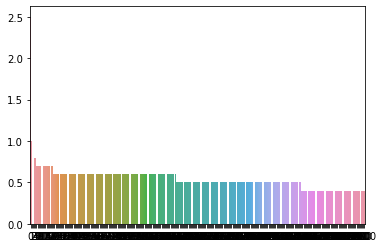

(('power', 2.5), ('imported_cases_per_step', 0.8), ('scale_factor', 500))
{0: 2.5, 1: 1.0, 2: 0.9, 3: 0.8, 4: 0.8, 5: 0.7, 6: 0.7, 7: 0.7, 8: 0.7, 9: 0.7}
...
{920: 0.5, 930: 0.5, 940: 0.5, 950: 0.5, 960: 0.5, 970: 0.5, 980: 0.5, 990: 0.5, 1000: 0.5}


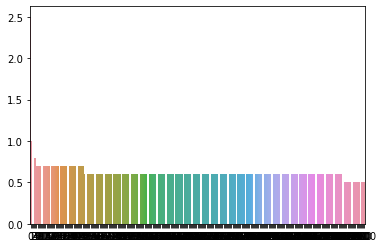

(('power', 2.5), ('imported_cases_per_step', 0.8), ('scale_factor', 1000))
{0: 2.5, 1: 1.0, 2: 0.9, 3: 0.8, 4: 0.8, 5: 0.7, 6: 0.7, 7: 0.7, 8: 0.7, 9: 0.7}
...
{920: 0.6, 930: 0.6, 940: 0.6, 950: 0.6, 960: 0.6, 970: 0.6, 980: 0.6, 990: 0.6, 1000: 0.6}


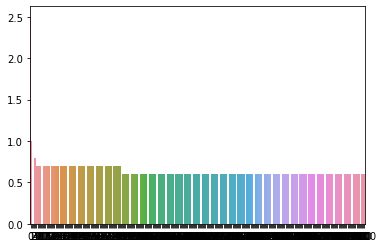

In [62]:
for key, value in list(policy_table.items()):
    best_action_idx = value['best_action_idx']
    print('=' * 100)
    print(key)
    print_policy_short(best_action_idx)
    plot_policy(best_action_idx)

In [ ]:
#sns.barplot(list(range(num_population)),
#            [state_values[bucket_state_index(n)] for n in range(num_population)])

sns.barplot(list(range(num_states)),
            [state_values[state_idx] for state_idx in range(num_states)])

In [ ]:
state_values.dtype

## State Actions

In [ ]:
#sns.barplot(list(range(num_population)),
#            [actions[best_action_idx[bucket_state_index(n)]] for n in range(num_population)])

sns.barplot(list(range(num_states)),
            [actions[int(best_action_idx[n])] for n in range(num_states)])

In [ ]:
{states[i]: actions[int(idx)] for i, idx in enumerate(best_action_idx)}

In [ ]:
# Roll-Out Using Optimal Policy

initial_cases = 100
current_state_idx = bucket_state_index(initial_cases)
total_reward = 0
current_discount = 1

action_history = []
state_history = [current_state_idx]

for i in tqdm(range(100)):
    action_idx = int(best_action_idx[current_state_idx])
    new_state_idx, new_reward = step(current_state_idx, action_idx)
    total_reward += new_reward * current_discount
    
    current_state_idx = new_state_idx
    current_discount *= discount
    
    action_history.append(actions[action_idx])
    state_history.append(states[current_state_idx])

In [ ]:
total_reward

### Attempt at facet plots...

In [123]:
sns.set(style="ticks")

In [ ]:
g = sns.FacetGrid(df[df['scale_factor'] == 100], col="imported_cases_per_step", row='power')
g.map(sns.barplot, 'case_count_n', 'best_action_r')
g.add_legend()
plt.show()

In [128]:
g = sns.relplot(x="case_count_n", y="best_action_r",
                hue="day", col="time", data=)

In [129]:
plt.show()

# Roll-Outs

## Case Counts

In [ ]:
sns.barplot(x=list(range(len(state_history))), y=state_history)

## R(t)

In [ ]:
sns.barplot(x=list(range(len(action_history))), y=action_history)